# Using an ML model to Predict Grades
- Certain features predict whether or not someone will have a high grade
- An ML model can be trained using the data from the class to show which features it uses to predict grades the most (shows the feature importances)

In [1]:
import pandas as pd  
import numpy as np 
import seaborn as sns
%matplotlib inline

## Read and clean the data
- First examine the data 
- There are less than 100 total records so data should not be dropped

In [ ]:
# note - this cell has been altered to remove showing any sensitive survey info
class_df = pd.read_csv('../clean_profile.csv')

### Isolate the target variable
- Since I am trying to build a model to predict 1A average, I will remove all of the target variables (the averages for each course) for the data

In [ ]:
# get the grades columns from the df and drop them from here as the predictions will come from here
grade_cols = [col for col in class_df.columns if col.startswith('What was your final')]
target = class_df[grade_cols].copy()
target.head()

In [ ]:
class_df.drop(columns=grade_cols, inplace=True)
class_df[[col for col in class_df.columns if class_df[col].dtype in ['int64', 'float64']]].head()

### Start by cleaning the numerical columns
- I will start by cleaning the numerical columns since they are the eaasiest to deal with
- Deal with discrete and continuious numerical columns differently
- Discrete columns were all entered by a check box and they are already clean
- Continuious data was uder entered and must be isolated and cleaned

In [ ]:
# check the int columns for numerical columns
numerical_cols = [col for col in class_df.columns if class_df[col].dtype in ['int64', 'float64']]
class_df[[col for col in class_df.columns if pd.api.types.is_integer_dtype(class_df[col].dtype)]]

In [ ]:
# make a list of discrete numerical columns
discrete_numerical = [
    'What year were you born?',
    'How many days of the week did you go outside on average? (During the 1A term)',
    'Rate your mental health before the term',
    'Rate your mental health during the term.',
    'Rate your mental health now',
    'How useful do you think a SYDE degree will be for the future?',
    'How useful do you think CO-OP will be for the future?',
    'How likely are you to move onto campus housing for the summer term?', 
    'What would you rate your perception of SYDE before 1A?',
    'What would you rate your perception of SYDE after 1A?'
]

# view the discrete numerical columns
class_df[discrete_numerical].head()

In [7]:
# get the continuous numerical columns, these were values that people entered and must be cleaned
cont_numerical = list(set(numerical_cols) - set(discrete_numerical))
cont_numerical

['What was your total cost first term? This is tuition + schooling supplies (textbooks, stationery, technology)  - scholarships. (do not include "$")',
 'What is your salary (in CAD/h, do not include "$")?',
 'How many hours of sleep did you get per night during school weeks on average (Not including naps)',
 'What was your top 6 highschool average for engineering? Please enter just the number with NO % sign (Calc, Adv Functions, English, Physics, Chemistry, 6th course in your top 6) ']

In [ ]:
# find number of NaN throughout the data set
na_per_col = class_df.isna().sum()[class_df.isna().sum() > 3]
print(na_per_col)

In [9]:
# clean the salaries since there are values that are too high and too low to be true - remove these
def remove_bad_salaries(row):
    salary = row['What is your salary (in CAD/h, do not include "$")?']
    if salary > 100 or salary < 10:
        row['What is your salary (in CAD/h, do not include "$")?'] = None
    
    return row

class_df = class_df.apply(remove_bad_salaries, axis=1)
print(class_df['What is your salary (in CAD/h, do not include "$")?'].isna().sum())

16


In [ ]:
class_df['What is your salary (in CAD/h, do not include "$")?'].head(30)

### Continuous Numerical Imputer
- Use an imputer to impute median values to all NaN continuous numerical variables, this way, all numerical data will be clean

In [ ]:
from sklearn.impute import SimpleImputer
# impute the 3 numerical columns that have NaN with median values
numerical_impute_cols = ['What was your top 6 highschool average for engineering? Please enter just the number with NO % sign (Calc, Adv Functions, English, Physics, Chemistry, 6th course in your top 6) ',
    'What is your salary (in CAD/h, do not include "$")?',
    'What was your total cost first term? This is tuition + schooling supplies (textbooks, stationery, technology)  - scholarships. (do not include "$")']

numerical_imputer = SimpleImputer(strategy='median')
original_cols = class_df.columns
class_df[numerical_impute_cols] = pd.DataFrame(numerical_imputer.fit_transform(class_df[numerical_impute_cols]))
class_df.columns = original_cols
class_df[numerical_impute_cols].head(30)


In [12]:
cont_na_sums = class_df[cont_numerical].isna().sum()[class_df[cont_numerical].isna().sum() > 3]
print(cont_na_sums)
# notice, the series is empty, all numerical values are filled

Series([], dtype: int64)


### Now, the categorical data must be dealt with
- In order to use mutual info, we must label encode any categorical data we choose to use
- Choose specific columns for categorical data. There are too many to clean and some are just fun/irrelevant questions
- Also, keep track of what has been cleaned in the categorical_cols list to not forget what is missing

In [13]:
categorical_cols = list(set(class_df.columns) - set(numerical_cols))
print(categorical_cols)

['Highest Parent Education', 'How difficult did you find each 1A course to be? [181]', 'Are you a Cat or Dog person?', 'What mental health challenges have you faced this semester?', 'Did at least one of your parents pursue a degree/career in STEM?', 'Which round did you get your coop in?', 'Timestamp', 'How useful did you find each of the 1A courses to be? [101L]', 'If you have used recreational drugs, which ones? (If you have not used drugs, indicate as such)', 'Religion', 'How difficult did you find each 1A course to be? [113]', 'How useful did you find each of the 1A courses to be? [181]', 'Roughly what percentage of lectures did you watch for each course?? [111]', 'Out of the previously mentioned universities, were you accepted or rejected from your program? If you did not apply to the university, indicate as such [McGill University]', 'How useful did you find each of the 1A courses to be? [111]', 'Out of the previously mentioned universities, were you accepted or rejected from you

In [ ]:
class_df[categorical_cols].head()

In [15]:
# get the columns that have to do with applying to universities and drop these
unis_applied_to = [col for col in class_df.columns if col.startswith('Out of the previously mentioned universities,')]
unis_applied_to

['Out of the previously mentioned universities, were you accepted or rejected from your program? If you did not apply to the university, indicate as such [Carleton University]',
 'Out of the previously mentioned universities, were you accepted or rejected from your program? If you did not apply to the university, indicate as such [McGill University]',
 'Out of the previously mentioned universities, were you accepted or rejected from your program? If you did not apply to the university, indicate as such [McMaster University]',
 "Out of the previously mentioned universities, were you accepted or rejected from your program? If you did not apply to the university, indicate as such [Queen's University]",
 'Out of the previously mentioned universities, were you accepted or rejected from your program? If you did not apply to the university, indicate as such [Ryerson University]',
 'Out of the previously mentioned universities, were you accepted or rejected from your program? If you did not ap

In [ ]:
categorical_cols = set(categorical_cols) - set(unis_applied_to)
class_df.drop(columns=unis_applied_to, inplace=True)
class_df.head()

In [ ]:
class_df[categorical_cols].head()

In [18]:
many_unique = list(set([col for col in class_df.columns if class_df[col].nunique() > 10]) - set(numerical_cols))
print(many_unique)

['Timestamp', 'How did you make friends/meet people during online school?', 'What are your plans after graduation (enter a short sentence)?', 'Which other types of programs did you apply to?', 'What is your #1 favorite activity to do for fun?', 'If you have used recreational drugs, which ones? (If you have not used drugs, indicate as such)', "What's your hometown?", 'Which country was your parent/guardian 2 born?', 'What mental health challenges have you faced this semester?', 'Religion', 'Which programming languages did you know before starting university?', 'If you answered Software for the previous question, what does your job entail? (If you did not answer Software, you can skip this question)', 'What was your favorite memory of Igor (a short sentence)', 'Political Alignment', 'Use one word to describe Igor. This response will be added to a word portrait. ', 'Which country was your parent/guardian 1 born?', 'What time did you wake up during school weeks on average (best guess relat

In [ ]:
class_df[many_unique]

### Drop Columns with too much variety
- Some columns from the list above are not helpful or have data this is too difficult to clean
- To scope down the effort, drop some of this data

In [20]:
varied_cols = [
    'Timestamp',
    'What are your plans after graduation (enter a short sentence)?',
    'What was your favorite memory of Igor (a short sentence)',
    'What is your #1 favorite activity to do for fun?',
    'Use one word to describe Igor. This response will be added to a word portrait. '
]

class_df.drop(columns=varied_cols, inplace=True)

In [ ]:
many_unique = list(set(many_unique) - set(varied_cols))
class_df[many_unique].head()

In [ ]:
categorical_cols = categorical_cols - set(varied_cols)
class_df[categorical_cols]

### There are still 50 categorical columns which is too many to clean. Choose a subset of these columns to clean/keep and drop the rest 

In [23]:
# find the categorical columns that have to do with course material
course_cols = [col for col in categorical_cols if col.startswith('How useful did') or col.startswith('Roughly') or col.startswith('How difficult')]
course_cols

['Roughly what percentage of lectures did you watch for each course?? [121]',
 'How difficult did you find each 1A course to be? [181]',
 'How useful did you find each of the 1A courses to be? [121]',
 'How useful did you find each of the 1A courses to be? [101L]',
 'How difficult did you find each 1A course to be? [101L]',
 'Roughly what percentage of lectures did you watch for each course?? [101L]',
 'Roughly what percentage of lectures did you watch for each course?? [181]',
 'How difficult did you find each 1A course to be? [113]',
 'How useful did you find each of the 1A courses to be? [181]',
 'Roughly what percentage of lectures did you watch for each course?? [111]',
 'How useful did you find each of the 1A courses to be? [111]',
 'Roughly what percentage of lectures did you watch for each course?? [101]',
 'How difficult did you find each 1A course to be? [121]',
 'How difficult did you find each 1A course to be? [161]',
 'How useful did you find each of the 1A courses to be? 

In [ ]:
class_df[course_cols].head()

In [25]:
# not_first_two_cols = [col for col in class_df.columns if not(col == 'Ethnicity' or col =='Timestamp')]
# # look at person id 70 and 71
# null_index = class_df[not_first_two_cols].isnull().all(axis=1)
# not_first_two_cols

In [26]:
# class_df.drop([70, 71], inplace=True)
# class_df

### Deal with all of the categorical columns related to courses
- The 'How useful' and 'How difficult' can be manually label encoded while 'Roughly' should just drop the % sign and turn to int

In [27]:
# check if there are NA values in these columns since they will be done manually
class_df[course_cols].isna().sum()

Roughly what percentage of lectures did you watch for each course?? [121]     0
How difficult did you find each 1A course to be? [181]                        0
How useful did you find each of the 1A courses to be? [121]                   0
How useful did you find each of the 1A courses to be? [101L]                  0
How difficult did you find each 1A course to be? [101L]                       0
Roughly what percentage of lectures did you watch for each course?? [101L]    0
Roughly what percentage of lectures did you watch for each course?? [181]     0
How difficult did you find each 1A course to be? [113]                        0
How useful did you find each of the 1A courses to be? [181]                   1
Roughly what percentage of lectures did you watch for each course?? [111]     0
How useful did you find each of the 1A courses to be? [111]                   0
Roughly what percentage of lectures did you watch for each course?? [101]     0
How difficult did you find each 1A cours

In [28]:
class_df['How useful did you find each of the 1A courses to be? [101]'].value_counts()

Useless             34
Somewhat Useless    25
Neutral             18
Somewhat Useful     16
Very Useful          1
Name: How useful did you find each of the 1A courses to be? [101], dtype: int64

In [29]:
class_df['How difficult did you find each 1A course to be? [101]'].value_counts()

Easy                  65
Somewhat Easy         21
Neutral                6
Somewhat Difficult     1
Very Difficult         1
Name: How difficult did you find each 1A course to be? [101], dtype: int64

In [30]:
class_df['Roughly what percentage of lectures did you watch for each course?? [101]'].value_counts()

100%    27
25%     25
0%      20
75%     16
50%      6
Name: Roughly what percentage of lectures did you watch for each course?? [101], dtype: int64

In [31]:
def handle_course_cols(row):
    """
    Turn each of the categorical columns that have to do with courses into integers either through mappings or string manipulation
    """
    # deal with the empty 181 by placing it as a value of 2 (same as neutral)
    usefulness_mappings = {'Useless': 0, 'Somewhat Useless': 1,'Neutral': 2, 'Somewhat Useful': 3,'Very Useful': 4, np.NaN: 2}
    difficulty_mappings = {'Easy': 4, 'Somewhat Easy': 3, 'Neutral': 2, 'Somewhat Difficult': 1, 'Very Difficult': 0} 
    class_list = ['[101]', '[101L]', '[111]', '[113]', '[121]', '[161]', '[181]']   

    for syde_class in class_list:
        row[f'How useful did you find each of the 1A courses to be? {syde_class}'] = usefulness_mappings[row.get(f'How useful did you find each of the 1A courses to be? {syde_class}')]
        row[f'How difficult did you find each 1A course to be? {syde_class}'] = difficulty_mappings[row.get(f'How difficult did you find each 1A course to be? {syde_class}')]
        # only 2 empty recors for 113, fill them in with 50s (in the middle)
        # print(row[f'Roughly what percentage of lectures did you watch for each course?? {syde_class}'])

        # row[f'Roughly what percentage of lectures did you watch for each course?? {syde_class}'] = int(row.get(f'Roughly what percentage of lectures did you watch for each course?? {syde_class}')[:-1]) if row.get(f'Roughly what percentage of lectures did you watch for each course?? {syde_class}') != np.NaN else 50

        if type(row[f'Roughly what percentage of lectures did you watch for each course?? {syde_class}']) != float:
             row[f'Roughly what percentage of lectures did you watch for each course?? {syde_class}'] = int(row.get(f'Roughly what percentage of lectures did you watch for each course?? {syde_class}')[:-1])
        else:
            row[f'Roughly what percentage of lectures did you watch for each course?? {syde_class}'] = 50
    
    return row

In [ ]:
# confirm that all of the data is now numerical and there are 94 non-null in each
class_df.apply(handle_course_cols, axis=1)[course_cols].info()

In [ ]:
class_df = class_df.apply(handle_course_cols, axis=1)
class_df[course_cols].head()

In [ ]:
# remove the columns from the set of categorical cols
categorical_cols = categorical_cols - set(course_cols)
class_df[categorical_cols].head()

In [35]:
# one hot encode the gender
gender_df = pd.get_dummies(class_df["What is your gender?"])

In [ ]:
class_df = class_df.join(gender_df)
class_df.head()

In [37]:
# remove the gneder call after OH encoding it
class_df.drop(columns=['What is your gender?'], inplace=True)

In [ ]:
categorical_cols = categorical_cols - set(['What is your gender?'])
class_df[categorical_cols].head()

In [39]:
categorical_cols

{'Approximately how many friends do you talk to weekly? (Estimate) [In SYDE]',
 'Approximately how many friends do you talk to weekly? (Estimate) [Not in SYDE]',
 'Are you a Cat or Dog person?',
 'Did at least one of your parents pursue a degree/career in STEM?',
 'Do you put cereal before milk or milk before cereal?',
 'Ethnicity',
 'Had you had sexual intercourse before starting university?',
 'Have you had sexual intercourse since starting university?',
 'Highest Parent Education',
 'How did you make friends/meet people during online school?',
 'If you answered Software for the previous question, what does your job entail? (If you did not answer Software, you can skip this question)',
 'If you have used recreational drugs, which ones? (If you have not used drugs, indicate as such)',
 'Political Alignment',
 'Religion',
 'Were you in a specialized high school program?',
 'What is your favourite programming language?',
 'What is your sexuality?',
 'What mental health challenges have y

In [ ]:
class_df[categorical_cols].nunique()

In [41]:
class_df[categorical_cols].isna().sum()[class_df[categorical_cols].isna().sum() > 0]

What is your favourite programming language?                                                                                                    2
Highest Parent Education                                                                                                                        1
Which programming languages did you know before starting university?                                                                            1
If you answered Software for the previous question, what does your job entail? (If you did not answer Software, you can skip this question)    40
Which round did you get your coop in?                                                                                                           3
Political Alignment                                                                                                                             1
Do you put cereal before milk or milk before cereal?                                                                        

In [ ]:
# drop 'If you answered Software for the previous question, what does your job entail? (If you did not answer Software, you can skip this question)', too many answers
class_df.drop(columns=['If you answered Software for the previous question, what does your job entail? (If you did not answer Software, you can skip this question)'], inplace=True)
class_df.head()

In [ ]:
pd.Series(class_df['Which programming languages did you know before starting university?'].unique()).str.split(';')

### Clean the remaining, difficult categorical columns
- Build a custom function to get unique categorical responses
- Build a unique function to one hot encode the data

In [44]:
from typing import List
def get_unique_responses(col_name: str) -> List[str]:
    """
    Given a column name, return the unique entries for that column
    """
    return_list = []
    unique_response_series = pd.Series(class_df[col_name].unique()).str.split(';')
    # iterate through eahc list of responses and get only uniqe responses
    for index, val in unique_response_series.items():
        # check that the item is not NaN
        if type(val) != float:
            for item in val:
                if item not in return_list:
                    return_list.append(item)
    return return_list

In [45]:
def find_sub(val, category):
    """
    Checks if a category is in series and returns 1 if true
    """
    # check that it is not NaN
    if type(val) != float and val.find(category) != -1:
        return 1
    else:
        return 0

### Some categories will need to manually be OH encoded since people added various combinations, so some responses are ';' separated
- I (Nick) will get the team to help me with some of the cleaning since it is a lot of manual work
- Mental health challenges (Alan)
- How did you meet people (Sean) done
- Specialized high school programs (Nirmal)
- Ethnicity (Nirmal)
- Drugs (Alan)
- Political Alignment (Nirmal)
- Programming languages pre uni (Nick)
- Other types of programs you applied to (Alan)
- Sector for coop (Sean) done
- Sexuality (Sean)

### Deal with Hard Data
- Use the custom functions above to first get unique responses and then one hot encode the data based on the unique categories in a column

In [46]:
#how did you meet people

unique_meets = get_unique_responses('How did you make friends/meet people during online school?')
unique_meets

['Discord',
 'Instagram',
 'Messenger',
 'Knew people going into SYDE',
 'I lived on campus',
 'group projects!',
 'Glimpse',
 'I did not meet people',
 'Group Projects',
 'Class projects',
 'Wechat',
 'Course Projects',
 'group work']

In [47]:
for meet in unique_meets:
    class_df[meet] = class_df['How did you make friends/meet people during online school?'].apply(find_sub, args=(meet,))
class_df[unique_meets]
#consolidate projects/group work
class_df["Group Projects"] = (class_df["Group Projects"] + class_df["Class projects"] + class_df["Course Projects"] + class_df["group work"] \
    + class_df["group projects!"]).astype(bool).astype(int)

class_df.drop(columns=['Class projects','Course Projects', "group work", "group projects!"], inplace=True)

In [48]:
class_df.drop(columns='How did you make friends/meet people during online school?', inplace=True)

In [49]:
#coop sector

unique_coop = get_unique_responses('Which sector was your first co-op in?')
unique_coop

['Software',
 'Other',
 'UI/UX',
 'Hardware',
 'Product Design',
 'Unhired',
 'Product Management']

In [ ]:
for coop in unique_coop:
    class_df[coop] = class_df['Which sector was your first co-op in?'].apply(find_sub, args=(coop,))
#consolidate projects/group work
class_df[unique_coop]

In [51]:
class_df.drop(columns = ["Which sector was your first co-op in?"],inplace = True, axis = 1)

In [52]:

unique_sex = get_unique_responses('What is your sexuality?')
unique_sex

['Heterosexual',
 'Homosexual',
 'Bisexual',
 'Asexual (including demisexual and others)',
 'Prefer not to say',
 'Pansexual']

In [ ]:
for sex in unique_sex:
    class_df[sex] = class_df['What is your sexuality?'].apply(find_sub, args=(sex,))
#consolidate projects/group work
class_df[unique_sex]

In [54]:
class_df.drop(columns = ["What is your sexuality?"],inplace = True, axis = 1)

In [55]:
# example for manually OH encoding programming langauges pre uni
unique_langs = get_unique_responses('Which programming languages did you know before starting university?')
unique_langs

['Python',
 'JavaScript/TypeScript',
 'HTML/CSS',
 'C Family (C, C++, C#)',
 'None',
 'Java',
 'SQL',
 'Swift',
 'Processing ',
 'Ruby',
 'Kotlin',
 'Turing',
 'Processing']

In [56]:
# Remove 'Processing '
unique_langs.pop(8)

'Processing '

In [ ]:
# print(unique_langs)
# loop through all unique langs and OH encode them
for lang in unique_langs:
    if lang != 'None':
        print(lang)
        class_df[lang] = class_df['Which programming languages did you know before starting university?'].apply(find_sub, args=(lang,))
    else:
        class_df['No CS Language'] = class_df['Which programming languages did you know before starting university?'].apply(find_sub, args=(lang,))
        unique_langs[4] = 'No CS Language'
        # unique_langs.append('No CS Language')

class_df[unique_langs].head()

In [58]:
# fill in the removed processing value
class_df['Processing'][90] = 1

In [59]:
class_df.drop(columns='Which programming languages did you know before starting university?', inplace=True)

In [ ]:
class_df.head()

In [ ]:
drugs = get_unique_responses('If you have used recreational drugs, which ones? (If you have not used drugs, indicate as such)')
drugs

In [ ]:
for drug in drugs:
    class_df[drug] = class_df['If you have used recreational drugs, which ones? (If you have not used drugs, indicate as such)'].apply(find_sub, args=(drug,))

class_df[drugs].head()

In [63]:
class_df.drop(columns='If you have used recreational drugs, which ones? (If you have not used drugs, indicate as such)', inplace=True)

In [64]:
challenges = get_unique_responses('What mental health challenges have you faced this semester?')
challenges

['Anxiety',
 'Depression',
 'Stress',
 'Loneliness',
 'None',
 'Trauma',
 'Pandemic and state of the world based anxiety (unrelated to school)',
 'imposter syndrome']

In [ ]:
for challenge in challenges:
    if challenge != 'None':
        class_df[challenge] = class_df['What mental health challenges have you faced this semester?'].apply(find_sub, args=(challenge,))
    else:
        class_df['No mental health'] = class_df['What mental health challenges have you faced this semester?'].apply(find_sub, args=(challenge,))
        challenges[4] = 'No mental health'
        # challenges.append('No mental health')
class_df[challenges].head()

In [66]:
class_df.drop(columns='What mental health challenges have you faced this semester?', inplace=True)

In [ ]:
programs = get_unique_responses('Which other types of programs did you apply to?')
programs

In [ ]:
for program in programs:
    class_df[program] = class_df['Which other types of programs did you apply to?'].apply(find_sub, args=(program,))

class_df[programs].head()

In [69]:
class_df.drop(columns='Which other types of programs did you apply to?', inplace=True)

In [ ]:
ethnicities = get_unique_responses('Ethnicity')
ethnicities.pop(6)
ethnicities

In [ ]:
for ethnicity in ethnicities:
    class_df[ethnicity] = class_df['Ethnicity'].apply(find_sub, args=(ethnicity,))

class_df[ethnicities].head()

In [72]:
class_df.drop(columns='Ethnicity', inplace=True)

In [ ]:
politics = get_unique_responses('Political Alignment')
politics

In [ ]:
for politic in politics:
    class_df[politic] = class_df['Political Alignment'].apply(find_sub, args=(politic,))

class_df[politics].head()

In [75]:
class_df.drop(columns='Political Alignment', inplace=True)

In [ ]:
programs = get_unique_responses('Were you in a specialized high school program?')
programs

In [ ]:
for program in programs:
    class_df[program] = class_df['Were you in a specialized high school program?'].apply(find_sub, args=(program,))

# group certain programs
class_df['French Immersion'] = (class_df["Full French"] + class_df["French Immersion"]).astype(bool).astype(int)
class_df['None'] = (class_df["None"] + class_df['I did IB for 3 years then dropped, what does that count as?'] + class_df["gifted didn't exist at high school level but I was in it from grs 1-8"] + class_df['GCE A-Levels (grade-based system - highschool grades: 3 A*s and 1 A) ']).astype(bool).astype(int)
class_df['Other specialized programs'] = (class_df['HMST'] + class_df['SHSM'] + class_df['SciTech '] + class_df['TOPS']).astype(bool).astype(int)
programs.append('Other specialized programs')

drop_list = ["Full French", 'I did IB for 3 years then dropped, what does that count as?', "gifted didn't exist at high school level but I was in it from grs 1-8", "GCE A-Levels (grade-based system - highschool grades: 3 A*s and 1 A) ", 'HMST', 'SHSM', 'SciTech ', 'TOPS']

# remove grouped programs from the program list
for col in drop_list:
    programs.remove(col)

drop_list.append('Were you in a specialized high school program?')
class_df[programs].head()

In [78]:
class_df.drop(columns=drop_list, inplace=True)

In [79]:
class_df['What time did you wake up during school weeks on average (best guess relative to your timezone)? '].isna().sum()

0

In [80]:
# convert wake up times to float values to use for the model
def time_to_float(row):
    time = row['What time did you wake up during school weeks on average (best guess relative to your timezone)? ']
    if pd.isnull(time):
        return row
    hours, minutes = time.split(':')
    decimal_time = round(int(hours) + (int(minutes) / 60), 2)
    row['What time did you wake up during school weeks on average (best guess relative to your timezone)? '] = decimal_time
    return row

In [ ]:
class_df = class_df.apply(time_to_float, axis=1)
class_df['What time did you wake up during school weeks on average (best guess relative to your timezone)? '].head(20)

In [82]:
categorical_cols = categorical_cols - set(('Which programming languages did you know before starting university?', 
    'Which other types of programs did you apply to?', 'What mental health challenges have you faced this semester?', 
    'If you have used recreational drugs, which ones? (If you have not used drugs, indicate as such)', 
    "What is your sexuality?", "Which sector was your first co-op in?", 'How did you make friends/meet people during online school?',
    'If you answered Software for the previous question, what does your job entail? (If you did not answer Software, you can skip this question)', 'Ethnicity', 'Political Alignment', 'Were you in a specialized high school program?', 'What time did you wake up during school weeks on average (best guess relative to your timezone)? '))

In [83]:
categorical_cols

{'Approximately how many friends do you talk to weekly? (Estimate) [In SYDE]',
 'Approximately how many friends do you talk to weekly? (Estimate) [Not in SYDE]',
 'Are you a Cat or Dog person?',
 'Did at least one of your parents pursue a degree/career in STEM?',
 'Do you put cereal before milk or milk before cereal?',
 'Had you had sexual intercourse before starting university?',
 'Have you had sexual intercourse since starting university?',
 'Highest Parent Education',
 'Religion',
 'What is your favourite programming language?',
 'What university would you go to if you were not going to Waterloo?',
 'What was your MAIN reason for choosing SYDE?',
 "What's your hometown?",
 'Which country was your parent/guardian 1 born?',
 'Which country was your parent/guardian 2 born?',
 'Which round did you get your coop in?'}

In [ ]:
class_df.head()

In [ ]:
obj_cols = [col for col in class_df.columns if class_df[col].dtype == 'object']
# unaccounted_obj_cols = set(obj_cols) - categorical_cols
# print(unaccounted_obj_cols)
class_df[obj_cols].info()

### Deal with the remaining categorical columns (Above)
- Use a most frequent imputer and ordinal encoder on the remaining catgerorical columns

### Combine target data into a single average
- Right now the target data is split between multiple courses
- Should be in a single average column as the target 

In [ ]:
target.dropna(axis=0, inplace=True)
target

In [ ]:
target['What was your final grade for 101L?'] /= 2
target['What was your final grade for 101?'] /= 2
target['What was your final grade for 113?'] /= 2   
target['averages'] = target.apply(lambda row: row.sum()/5.5, axis=1)
target['averages']


In [ ]:
target.drop(columns= grade_cols, inplace=True)
target

In [ ]:
target.index

In [91]:
target_index = target.index
to_drop = []
for i in range(94):
    if i not in target_index:
        to_drop.append(i)

to_drop

[16, 72, 76]

In [ ]:
class_df.drop(index=to_drop, inplace=True)
class_df.index

In [93]:
class_df[[col for col in class_df.columns if class_df[col].dtype == 'int64']].isna().any().sum()


0

In [94]:
class_df[[col for col in class_df.columns if class_df[col].dtype == 'float64']].isna().any().sum()

0

In [95]:
class_df[[col for col in class_df.columns if class_df[col].dtype == 'object']].isna().any().sum()

7

### Add a preprocessor for the remaining columns
- Should use label encoding on the remaining high cardinality columns 
- Should use one hot encoding on the remaining low cardinality columns
- Impute the categorical columns using the most frequent approach
- Add preprocessor for numerical wake up times

In [96]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# TODO: Ask about most frequent vs constant for categorical cols
categorical_encoder = Pipeline(steps = [
    ('Impute', SimpleImputer(strategy='constant')),
    ('OH Encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# low_card_encoder = Pipeline(steps = [
#     ('Impute', SimpleImputer(strategy='most frequent'),
#     ('OH Encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
# ])

numerical_encoder = SimpleImputer(strategy='median')

preprocessor = ColumnTransformer(
    transformers = [
        ('categorical', categorical_encoder, categorical_cols),
    ]
)

In [ ]:
# apply the categorical encoder to the entire dataset to finish data cleaning
# columns = class_df.columns
categorical_cols = list(categorical_cols)
encoded_categorical_df = pd.DataFrame(categorical_encoder.fit_transform(class_df[categorical_cols]), index=class_df.index, columns=categorical_encoder['OH Encoder'].get_feature_names())
# oh_col_names = categorical_encoder['OH Encoder'].get_feature_names()
# encoded_categorical_df = pd.DataFrame(encoded_categorical_array, index=class_df.index, columns=categorical_cols)
# class_df[categorical_cols] = encoded_categorical_df
class_df.drop(columns=categorical_cols, inplace=True)
class_df = class_df.join(encoded_categorical_df)
class_df

In [98]:
# confirm that everything is filled
class_df.isna().any().sum()

0

In [ ]:
class_df.columns = class_df.columns.map(lambda col_name: col_name.replace(']', '').replace('[', '').replace('<', ''))
class_df.columns

### Make a model to find the most important features to predict grades
- First use a simple XGB model
- For practice: Use random forest
- Use optuna for hyper parameter tuning
- Run it again to find the final important features

In [100]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error
!pip install xgboost
from xgboost import XGBRegressor
def score_model(X, y, model):
    """
    Score a model assuming that the incoming data is clean

    A better model = better predicting features -> more accurate results for factors that predict grades
    """
    scores = -1 * cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    return scores.mean()

In [ ]:
# make a basic xg boost model and check initial important features
X_basic_train, X_basic_test, y_basic_train, y_basic_test = train_test_split(class_df, target, test_size=0.2, random_state=0)
basic_xgb = XGBRegressor(learning_rate=0.05, n_estimators=1000, n_jobs=-1)
basic_xgb.fit(X_basic_train, y_basic_train, early_stopping_rounds=8, eval_set=[(X_basic_test, y_basic_test)])


In [102]:
# make predictions to see how good the model is
predictions = basic_xgb.predict(X_basic_test)
mae = mean_absolute_error(predictions, y_basic_test)
print(mae)


7.4550610409969345


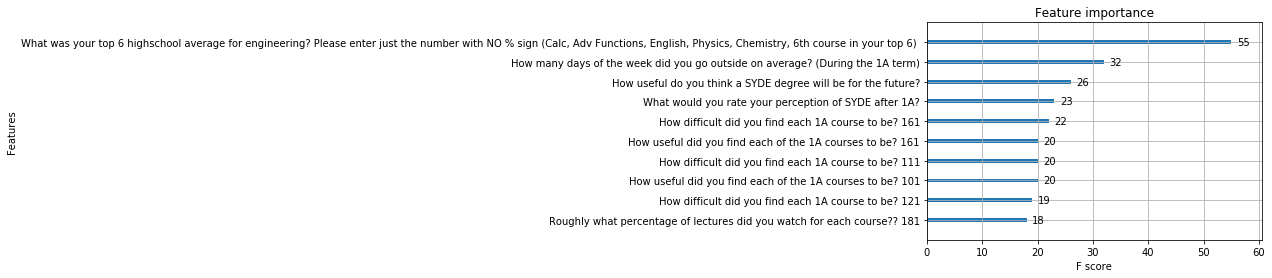

In [103]:
# using this basic model, find the important features
import xgboost as xgb
xgb.plot_importance(basic_xgb, max_num_features=10)

## Hyper Parameter Tuning
- After finding the features that predict grades for a basic model, we can use hyperparameter tuning to make a new model and get better results
- I will use the optuna library to hyperparameterize an xgb model and get a final answer as to which features predict grades

In [116]:
!pip install optuna
import optuna

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1), 
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 10),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),  
        'gamma': trial.suggest_float('gamma', 0.5, 2.5)
    }
    xgb = XGBRegressor(**params)
    return score_model(class_df, target, xgb)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
best_hyper_params = study.best_params

You should consider upgrading via the 'c:\program files\python.exe -m pip install --upgrade pip' command.
[I 2021-04-17 11:39:51,884] A new study created in memory with name: no-name-9be641c3-972a-454d-9902-a9632c4920f5
Defaulting to user installation because normal site-packages is not writeable
[I 2021-04-17 11:40:04,597] Trial 0 finished with value: 4.6597832346646975 and parameters: {'max_depth': 3, 'learning_rate': 0.04161380319074252, 'n_estimators': 2807, 'min_child_weight': 3, 'colsample_bytree': 0.6084719020664409, 'subsample': 0.8253046232806533, 'gamma': 2.283408892111788}. Best is trial 0 with value: 4.6597832346646975.
[I 2021-04-17 11:40:16,674] Trial 1 finished with value: 4.822627999743268 and parameters: {'max_depth': 3, 'learning_rate': 0.08644769783539849, 'n_estimators': 2640, 'min_child_weight': 6, 'colsample_bytree': 0.7499434909619788, 'subsample': 0.5196237171581228, 'gamma': 0.5732053162179134}. Best is trial 0 with value: 4.6597832346646975.
[I 2021-04-17 11:4

In [105]:
print(best_hyper_params)

{'max_depth': 4, 'learning_rate': 0.05060054422935693, 'n_estimators': 1278, 'min_child_weight': 3, 'colsample_bytree': 0.802597939838787, 'subsample': 0.6715104536211687, 'gamma': 1.7450082570665013}


## Use the hyper parameter above to create a final model
- Given the best hyperparamters from the hyperparamter tuning above, a final xgboost model will be created
- All the data will be used to train this model
- The most important features which predict grades for the model will be determined

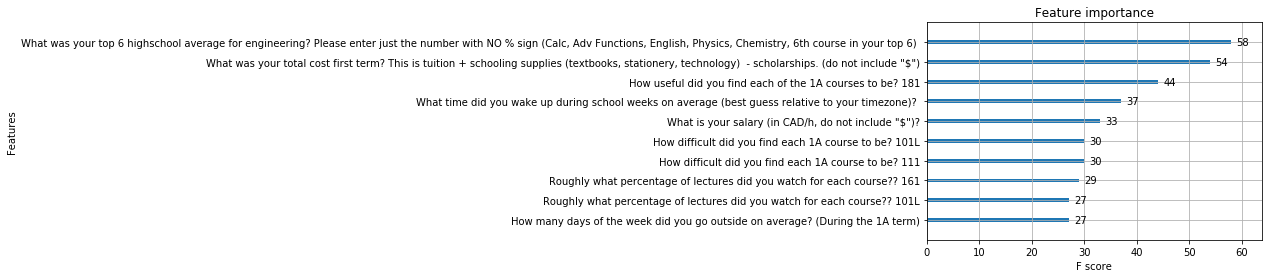

In [106]:
# make a final model using all the data and best hyper params to predict top features
final_xgb_model = XGBRegressor(**best_hyper_params)
final_xgb_model.fit(class_df, target)
xgb.plot_importance(final_xgb_model, max_num_features=10)


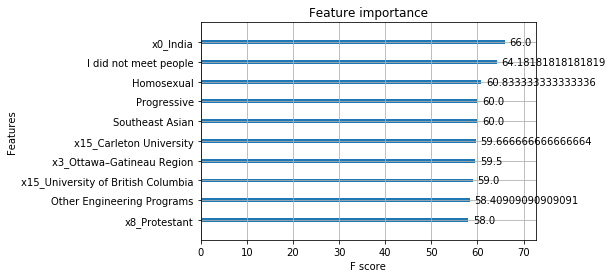

In [107]:
xgb.plot_importance(final_xgb_model,importance_type="cover", max_num_features=10)

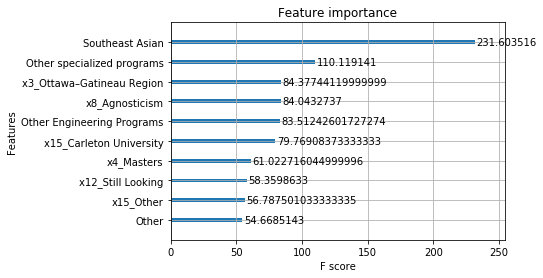

In [108]:
xgb.plot_importance(final_xgb_model,importance_type="gain", max_num_features=10)

## Feature Importance Results (Above)
- Notice that changing the impotance type greatly altered the important features 
- These results are not so simple to interpret/accurate so I will use the SHAP library to better find and interpret feature importance 

In [113]:
class_df.rename(columns={
    'What was your top 6 highschool average for engineering? Please enter just the number with NO % sign (Calc, Adv Functions, English, Physics, Chemistry, 6th course in your top 6) ': 'High School Admission Average', 
    'What was your total cost first term? This is tuition + schooling supplies (textbooks, stationery, technology)  - scholarships. (do not include "$")': 'Net 1A Cost (School Cost - Scholarships)',
    'What time did you wake up during school weeks on average (best guess relative to your timezone)? ': 'What time did you wake up?'
    }, inplace=True)

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the 'c:\program files\python.exe -m pip install --upgrade pip' command.


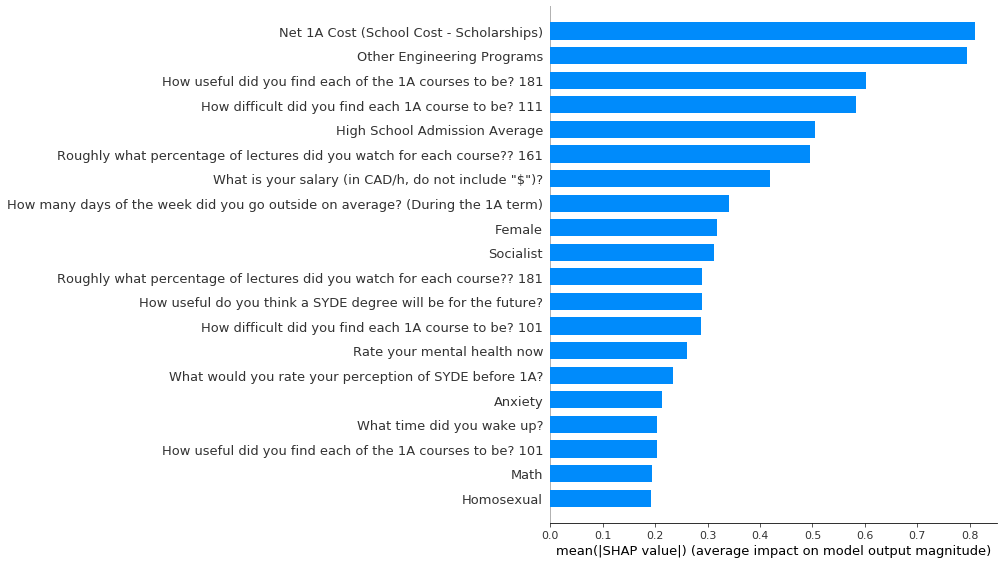

In [114]:
# use SHAP values to interpret the results
!pip install shap  
import shap

explainer = shap.TreeExplainer(final_xgb_model)
shap_values = explainer.shap_values(class_df)
shap.initjs()
shap.summary_plot(shap_values, class_df, plot_type='bar')

## SHAP Bar Results
- Although the shap bar results tell me which features affected student average predictions the post (NET 1A cost, other engineering programs, etc) it does not tell me **how** they affect grades
- Use the full SHAP summary plot to understand this better

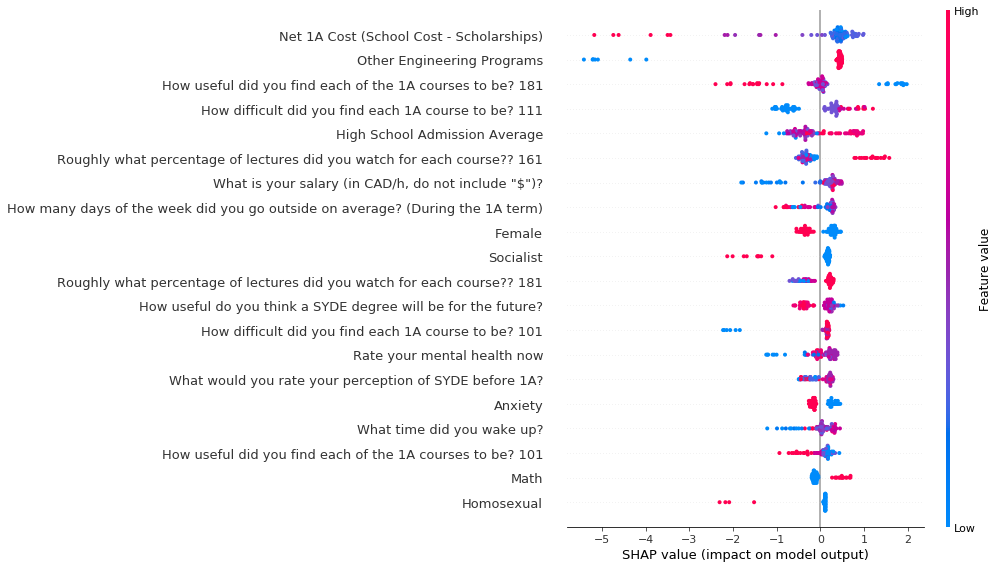

In [115]:
shap.summary_plot(shap_values, class_df)

## Using the model's shap values to find features that predict grades
Here are the results for the first 6 features in the graph:

- High and medium-high Net 1A Costs predicted much lower averages; low and medium-low Net 1A Costs predicted slightly higher averages
- Not applying to any Other Engineering Program other than SYDE predicted much lower averages, applying to Other Engineering Programs predicted slightly higher averages
- Rating SYDE 181 (Physics 1) as very useful predicted lower averages; rating SYDE 181 as very useless predicted higher averages
- Rating SYDE 111 (Calculus 1) as very difficult predicted slightly lower averages; rating SYDE 111 as very easy predicted slightly higher averages
- In some cases, high Admission Averages predicted slightly higher 1A averages
- In general, watching a very high Percentage of SYDE 161 (Introduction to Design) lectures predicted higher averages